In [2]:
from __future__ import division
import sys, os
import mplstereonet
import scipy
import scipy.fftpack
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

#load utils for importing data
sys.path.append("G:\My Drive\Documents\PhD\Analysis\libs")
import pycompass
#from pycompass.IOTools import ccXML
# from pycompass.SNE import pdf

os.chdir(r'G:\My Drive\Documents\PhD\Analysis\OrientationEstimation\notebook')

#setup matplotlib defaults
%matplotlib inline

plt.style.use(['default'])
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

ModuleNotFoundError: No module named 'pycompass'

Generate fractal topographies and structures:
===============

In [3]:
'''Generate isotropic fractal surface image using
spectral synthesis method [1, p.]
References:
1. Yuval Fisher, Michael McGuire,
The Science of Fractal Images, 1988

(cf. http://shortrecipes.blogspot.com.au/2008/11/python-isotropic-fractal-surface.html)
**Arguments**:
 -fd = the fractal dimension
 -N = the size of the fractal surface/image
     
'''
def fractalGrid(fd=2.5, N=256):
    H=1-(fd-2);
    X=np.zeros((N,N),complex)
    A=np.zeros((N,N),complex)
    powerr=-(H+1.0)/2.0

    for i in range(int(N/2)+1):
        for j in range(int(N/2)+1):
            phase=2*np.pi*np.random.rand()

            if i is not 0 or j is not 0:
                rad=(i*i+j*j)**powerr*np.random.normal()
            else:
                rad=0.0

            A[i,j]=complex(rad*np.cos(phase),rad*np.sin(phase))

            if i is 0:
                i0=0
            else:
                i0=N-i

            if j is 0:
                j0=0
            else:
                j0=N-j

            A[i0,j0]=complex(rad*np.cos(phase),-rad*np.sin(phase))

            A.imag[int(N/2)][0]=0.0
            A.imag[0,int(N/2)]=0.0
            A.imag[int(N/2)][int(N/2)]=0.0

    for i in range(1,int(N/2)):
        for j in range(1,int(N/2)):
            phase=2*np.pi*np.random.rand()
            rad=(i*i+j*j)**powerr*np.random.normal()
            A[i,N-j]=complex(rad*np.cos(phase),rad*np.sin(phase))
            A[N-i,j]=complex(rad*np.cos(phase),-rad*np.sin(phase))

    itemp=scipy.fftpack.ifft2(A)
    itemp=itemp-itemp.min()
    
    return itemp.real/itemp.real.max()

"""
Display a grid matplotlibs imshow function
"""
def draw(grid): 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    CM = ax.imshow(grid, cmap="Greys_r")
    fig.colorbar(CM)
    return fig

#utitlity function for plotting grids
def plotGrids(titles, grid, values):
    """
    Plots a list of values on a gridded stereonets. The grid is 
    is expected to be a complete hemisphere in lat/long coordinates.
    """
        
    nAxes = len(values) #number of axes to draw
    bound = np.pi / 2 #boundaries of the stereonet hemisphere
    minV = 99999999999999999 #min for color ramp
    maxV = -9999999999999999 #max for color ramp
    
    patches = [] #list of patch objects for each grid
    for i in range(len(values)):
        
        #build patches for this grid
        patches.append([])
        
        #loop through points in grid and create patch objects
        for _lat,_lon in grid.T:
            patches[i].append(mpl.patches.Circle( (_lon, _lat), .02)) #store "dot" for plotting
        
        #check minV and maxV
        if np.min(values[i]) < minV:
            minV = np.min(values[i])
        if np.max(values[i]) > maxV:
            maxV = np.max(values[i])
    
    #init figure
    fig = plt.figure(figsize=(8 * nAxes, 8))
    
    #build throw-away axes to get color-ramp object
    cmap_name = "coolwarm" #plasma
    ax = fig.add_subplot(111, projection='stereonet')
    x = np.linspace(minV,maxV)
    y = np.linspace(minV,maxV)
    CS3 = ax.scatter(x,y,c=x, cmap=cmap_name)
    fig.clf()
    
    #create normalization object for color-mapping
    #now create colour map
    cmap = mpl.cm.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=minV,vmax=maxV) 

    #build axes
    for i in range(nAxes):
        pos = "1%d%d" % (nAxes,i+1)
        ax = fig.add_subplot(pos, projection='stereonet')
        ax.set_title(titles[i],y=1.08)
        
        #reshape grid for matplotlib contourf
        res = int(np.sqrt(len(values[i])))
        assert res**2 == len(values[i]), "Error: values must be sampled from a square grid."
        vals = np.reshape(values[i],(res,res)).T

        #push contour points
        bound = np.pi / 2
        ax.contourf(np.linspace(-bound,bound,res),np.linspace(-bound,bound,res), vals,cmap="coolwarm")
        
    #finally, add the color-ramp
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    fig.colorbar(CS3, cax=cbar_ax)
    
    return fig

c:\users\lgrose\.conda\envs\loop\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


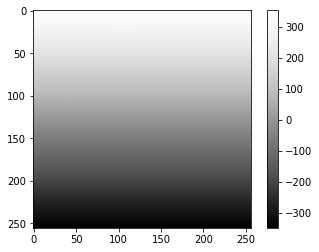

In [4]:
#create a dipping structure
"""
Create a planar structure dipping to the north
"""
def planarStructure(slope=45,N=256):
    grid = np.zeros( (N,N) )
    gradient = np.tan(np.deg2rad(slope))
    for x in range(N):
        for y in range(N):
            grid[x][y] = gradient * x - 0.5 * gradient * N
            
    return grid

simple_plane = planarStructure(-70,256) + fractalGrid(2,256) * 2.5 #n.b. we add some fractal noise to the structure also
fig = draw(simple_plane)
fig.show()

c:\users\lgrose\.conda\envs\loop\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


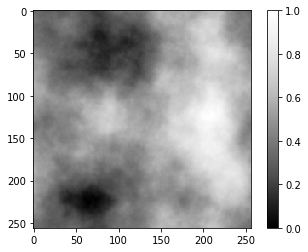

In [5]:
#build topography
topo = fractalGrid(2.1,256)

fig = draw(topo)
fig.show()

In [5]:
def getItc(plane1, plane2):
    diff=np.abs(plane1-plane2)
    mins = np.min(diff,axis=0)

    out = []
    for x in range(diff.shape[0]): #loop through columns [note the confusing x,y notation as np arrays are row-major while x,y 
                                                        # coords in the image are column major [x-axis specifies column]]
        y = np.where(diff[:,x] == mins[x])[0] #get coords of min-value
        out.append( [x,y, np.mean([plane1[y,x], plane2[y,x]])] ) #store

    return np.array(out).T

This is the real work happens:

In [12]:
#######################################################
#Generate random topographies for monte-carlo sampling
#######################################################
n_samples = 1000

#set seed
np.random.seed(1) #1

#generate topography arrays
topo = []
dims = 256
for i in range(n_samples):
    topo.append(fractalGrid(2.1,dims))

Reconstruct SNEs for sub-planar structure:
=======

Generate a planar structure:

In [13]:
simple_plane = planarStructure(-55,dims) + fractalGrid(2,dims) * 0.01*dims #n.b. we add 1% fractal noise to the structure also

Do monte-carlo sampling of random intersections and MCMC sampling using the SNE method based on the final (1000th) structure intersection only:

In [14]:
#define variables monte-carlo experiment
amplitudes = [0.04*dims,0.08*dims,0.2*dims] #10,20,50
grid = pdf.grid(100)
out_MC = [] #output density grids (for stereonets)
out_dip = [] #dip observations for histograms
titles = []

#define variables for mcmc bayesian sampling
outcrop_normal = np.array([0.0,0.0,1.0],dtype=np.double) #outcrop is flat
out_MCMC_grid = []
out_MCMC_samples = []
out_cov = []

#define variables for explicit bayesian calcs
out_posterior = []

res = 500
arc = np.array([np.linspace(-np.pi/2,0,res),[0]*res])

#Loop through topography amplitudes (each experimental group)
for a in amplitudes:
    ######################################################################################
    #1: Sample plausible orientations by repeatedly regenerating topography (monte-carlo)
    ######################################################################################
    samples = []
    dip_samples = []
    for i in range(n_samples):
        #calculate trace
        trace = getItc(simple_plane, topo[i]*a)

        #estimate structure normal
        cov = np.cov(np.vstack(trace))
        eigval,eigvec = np.linalg.eig(cov)
        idx = eigval.argsort()[::-1] #sort eigens in decending order...
        eigval = eigval[idx]
        eigvec = eigvec[:,idx] #n.b. columns of evec are vectors....
        
        phi,theta = pdf.vec2TrendPlunge(eigvec[:,2])
        samples.append([phi,theta]) #store sample
        dip_samples.append(np.rad2deg(theta))
        
    #grid samples
    out_MC.append(pdf.gridSamples(grid,np.array(samples)))
    out_dip.append(dip_samples)
    titles.append("A = %f" % a)
    
    
    #######################################################################################
    #2: Sample directly from posterior using MCMC and last observed covaraince matrix
    #######################################################################################
    samples = pdf.samplePosteriorMCMC(cov,10,outcrop_normal,n_samples)
    out_MCMC_grid.append( pdf.gridSamples(grid,samples) )
    out_MCMC_samples.append( np.rad2deg(samples[:,1]) )
    
    #######################################################################################################
    #3: Use last observed covariance matrix explicitely estimate posterior along arc of maximum uncertainty
    #######################################################################################################
    #arc = pdf.gridArc(cov,250)
    #out_posterior.append( pdf.posteriorExp1D(arc,cov,n,outcrop_normal,500) )
    out_posterior.append( pdf.posteriorExp1D(arc,cov,10,outcrop_normal,250) )
    out_cov.append(cov)

Sampled 1000 points in 737534 iterations. On average 737.0 iterations were needed per sample.
Sampled 1000 points in 371884 iterations. On average 371.0 iterations were needed per sample.
Sampled 1000 points in 322330 iterations. On average 322.0 iterations were needed per sample.


As with any MCMC sampler, it is important to check the sampler has converged properly for the results to be meaningful. This can be done by plotting the MCMC trace and checking that it is not overly autocorrelated and is not drifting away from the distribution center:

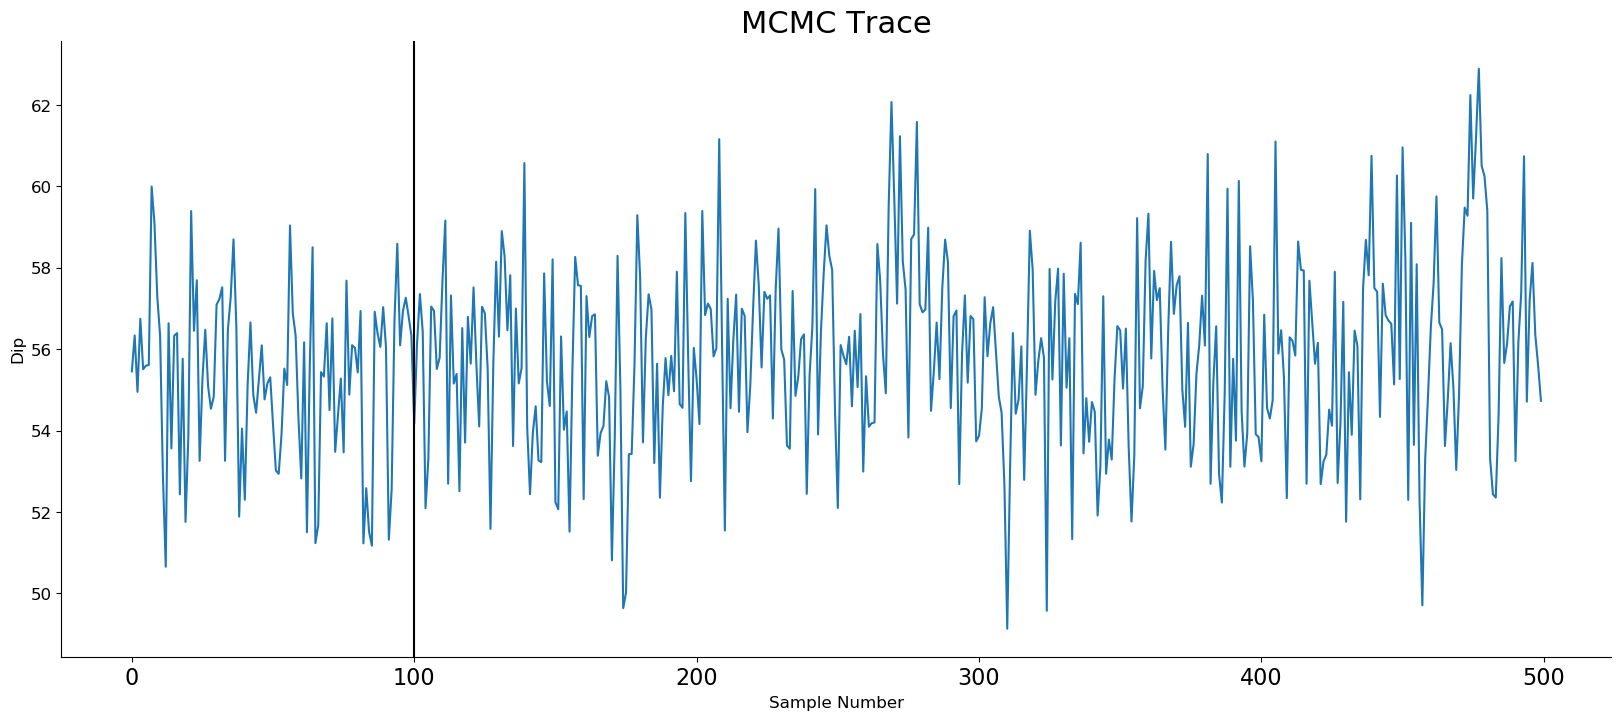

In [219]:
plt.figure(figsize=(20,8))
plt.plot(np.array(90-out_MCMC_samples[1])[0:500])
plt.xlabel("Sample Number")
plt.ylabel("Dip")
plt.title("MCMC Trace")
plt.axvline(100,color='k')

Plot histograms of monte-carlo sampled dip and the dip of the associated SNEs:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


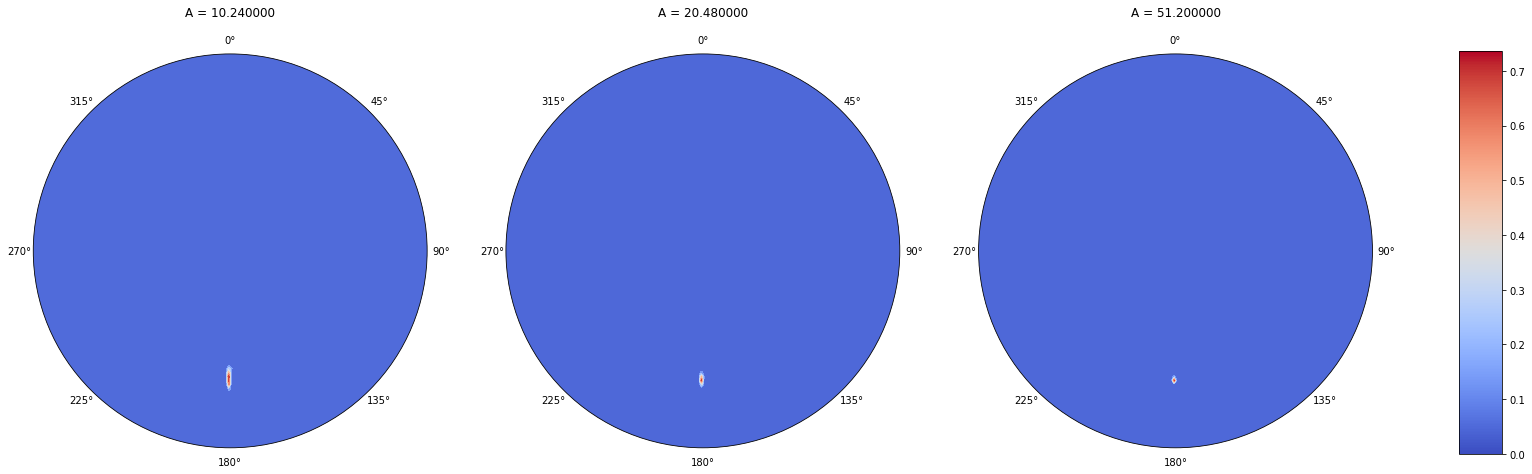

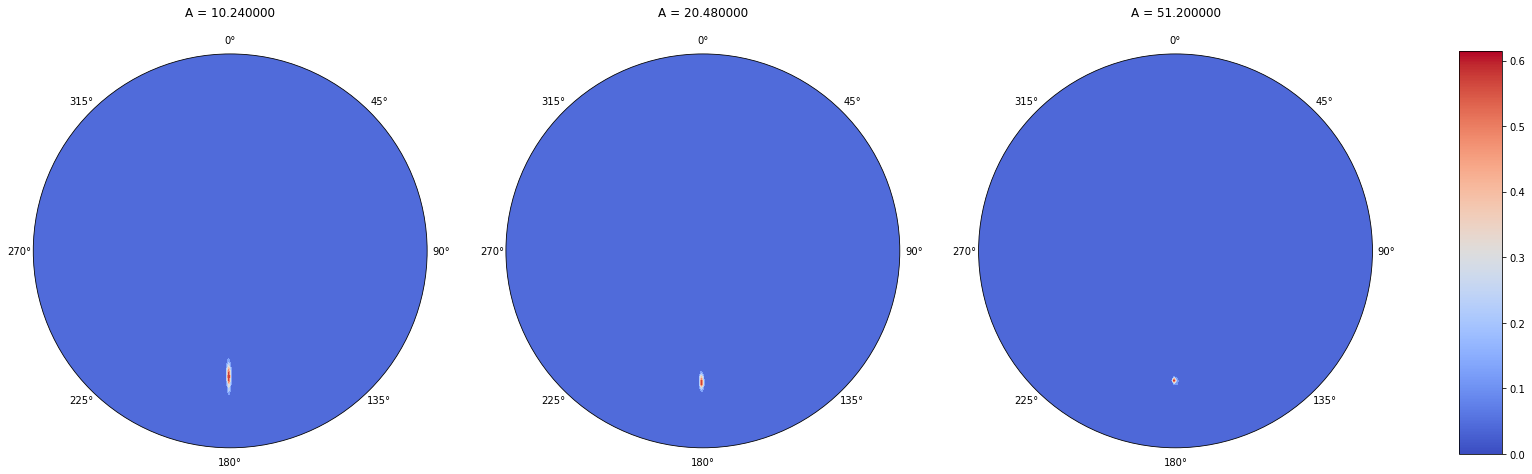

In [15]:
#plot monte-carlo results
fig = plotGrids(titles,grid,out_MC)
fig.show()

#plot monte-carlo markov-chain results
fig = plotGrids(titles,grid,out_MCMC_grid)
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


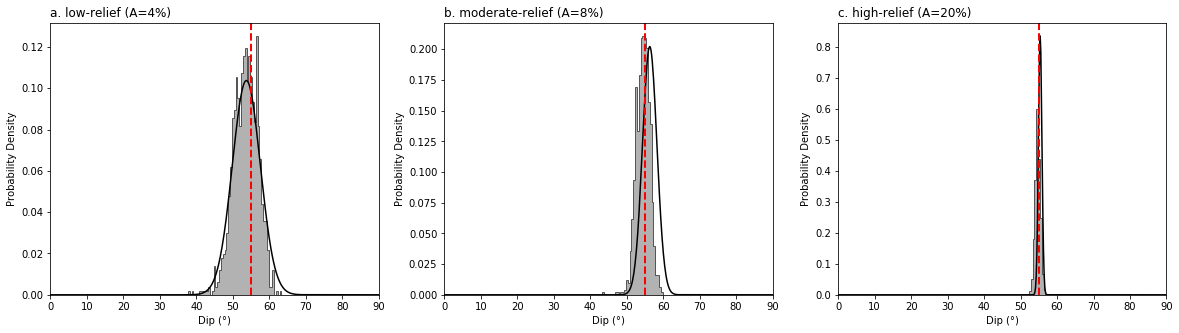

In [16]:
titles = ["a. low-relief (A=4%)","b. moderate-relief (A=8%)","c. high-relief (A=20%)"]
fig,ax = plt.subplots(1,len(out_dip),figsize=(20,5))
for i in range(len(out_dip)):
    for pp in [out_posterior[i]]:#,out_posterior_5[i],out_posterior_20[i]]:
        #normalise
        pp /= np.trapz(pp,np.rad2deg(arc[0]))

        #in this special case, plunge == 90+latitude (as lon = 0 and lat = 0 - -90)
        ax[i].plot(-np.rad2deg(arc[0]),pp,c='k',lw=1.5)
    ax[i].set_title(titles[i],loc='left')
    ax[i].set_xlabel("Dip (°)")
    ax[i].set_ylabel("Probability Density")
    ax[i].hist(90-np.array(out_dip[i]),bins=np.linspace(0,90,90*2),density=True,histtype='step',fill=True,color='gray',alpha=0.6,edgecolor='k')
    ax[i].axvline(55, color='r', linestyle='dashed', linewidth=2)
    ax[i].set_xlim(0,90)
fig.show()

Compute KDEs from both sets of samples and their corresponding overlap to quantify similarity between the MCMC posterior samples and the distribution defined by the monte-carlo sampling:

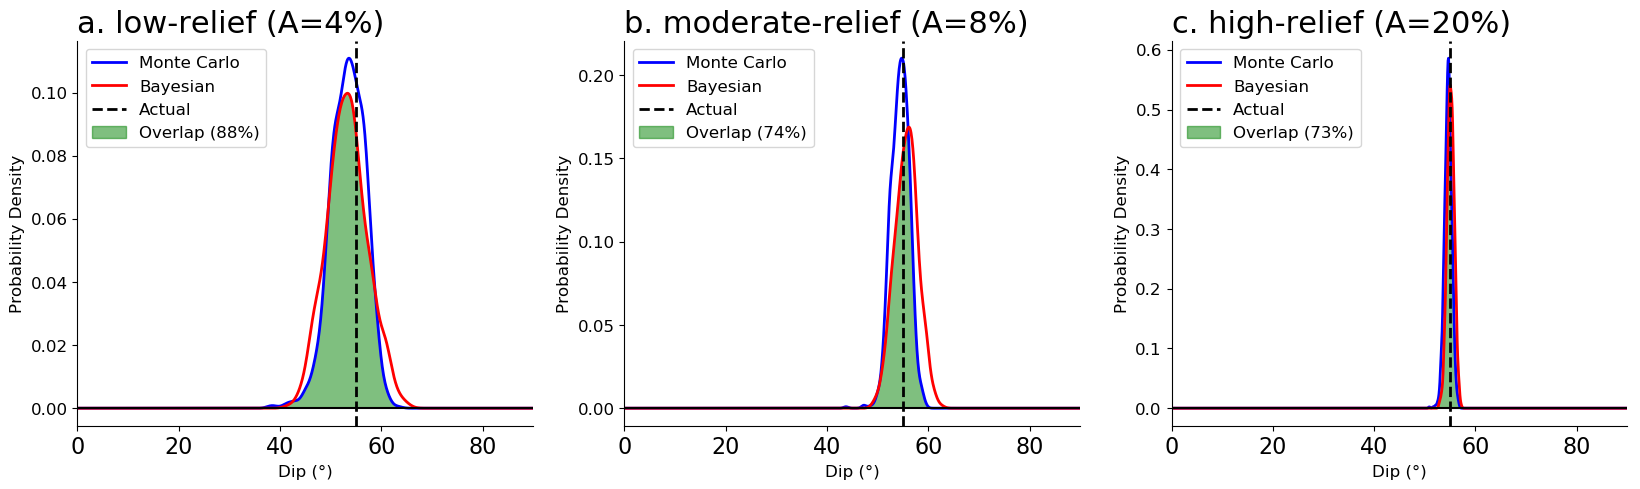

In [208]:
fig,ax = plt.subplots(1,len(out_dip),figsize=(20,5))
for i in range(len(out_dip)):
    
    #KDE
    _x = np.linspace(0,90,1000)
    _dens1 = scipy.stats.gaussian_kde(90-np.array(out_dip[i])).evaluate(_x)
    _dens2 = scipy.stats.gaussian_kde(90-np.array(out_MCMC_samples[i])).evaluate(_x)
    OC = np.trapz(np.min(np.vstack([_dens1,_dens2]),axis=0), _x)
    
    #ax[i].hist(out_dip[i],bins=100,normed=True,range=(0,90),alpha=0.5,color='blue')
    ax[i].plot(_x,_dens1,color="blue",lw=2,label="Monte Carlo")
    #ax[i].hist(out_MCMC_samples[i],bins=100,range=(0,90), normed=True, alpha=0.5,color="green")
    ax[i].plot(_x,_dens2,color="red",lw=2,label="Bayesian")
    
    #fill intersection
    ax[i].fill(_x,np.min(np.vstack([_dens1,_dens2]),axis=0),color="green",alpha=0.5,label="Overlap (%d%%)" %(100*OC))
    
    #plot actual value and axes
    ax[i].axvline(55, color='k', linestyle='dashed', linewidth=2, label="Actual")
    
    #setup plot
    ax[i].set_xlim(0,90)
    ax[i].set_title(titles[i],loc='left')
    ax[i].set_xlabel("Dip (°)")
    ax[i].set_ylabel("Probability Density")
    ax[i].legend()
plt.show()

Reconstruct SNEs for multi-planar example:
==================

Let's create a "multi-planar" function now and see if we can reconstruct it's orientation properly.

In [220]:
"""
Create a planar structure dipping to the north
"""
def multiStructure(slope=45,N=256):
    grid = np.zeros( (N,N) )
    gradient = np.tan(np.deg2rad(slope))
    for x in range(N):
        for y in range(N):
            if (x<y):
                grid[x][y] = gradient * x - 0.5 * gradient * N
            else:
                grid[x][y] = gradient * y + 0.5*gradient * (x-y) - 0.5 * gradient * N
            
    return grid

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


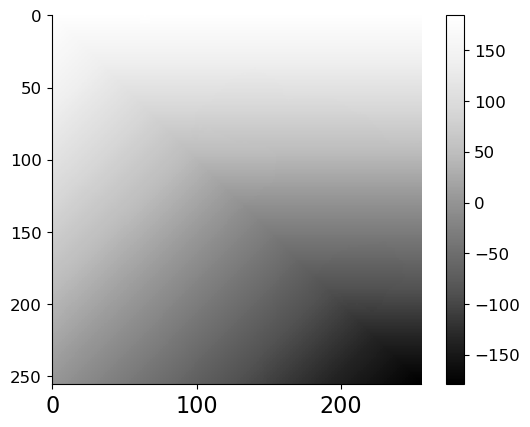

In [221]:
#build multiplane
multi_plane = multiStructure(-55,256) + fractalGrid(2,256) * 2.5 #n.b. we add some fractal noise to the structure also
fig = draw(multi_plane)
fig.show()

As in the previous example, we use the 1000 topographic datasets to characterise the inherent orientation uncertianty using monte-carlo, the only difference here being we split the plane into its two parts for this step to avoid incorrect planes.

We then give the last generated (1000th) trace to the bayesian MCMC SNE sampler, with no information on the change in orientation, to see how it performs!

In [222]:
#generate monte-carlo samples
amplitudes = [0.04*dims,0.08*dims,0.2*dims] #10,20,50
grid = pdf.grid(100)
out_MC = [] #output density grids (for stereonets)
out_samples_MC = []
titles = []

#define variables for mcmc bayesian sampling
outcrop_normal = np.array([0.0,0.0,1.0],dtype=np.double) #outcrop is flat
out_MCMC_grid = []
out_MCMC_samples = []
out_cov = []

#define variables for explicit bayesian calcs
out_posterior = []

res = 500
arc = np.array([np.linspace(-np.pi/2,0,res),[0]*res])


#Loop through topography amplitudes (each experimental group)
for a in amplitudes:
    ######################################################################################
    #1: Sample plausible orientations by repeatedly regenerating topography (monte-carlo)
    ######################################################################################
    samples = []
    dip_samples = []
    for i in range(n_samples):
        #calculate trace
        trace = getItc(multi_plane, topo[i]*a)
        
        #split trace into x < y and y x > y sections
        seg1 = []
        seg2 = []
        for x,y,z in trace.T:
            if x < y:
                seg1.append([x,y,z])
            else:
                seg2.append([x,y,z])
        seg1 = np.array(seg1).T
        seg2 = np.array(seg2).T
        
        for seg in [seg1,seg2]:
            #estimate structure normal
            cov = np.cov(np.vstack(seg))
            eigval,eigvec = np.linalg.eig(cov)
            idx = eigval.argsort()[::-1] #sort eigens in decending order...
            eigval = eigval[idx]
            eigvec = eigvec[:,idx] #n.b. columns of evec are vectors....

            phi,theta = pdf.vec2TrendPlunge(eigvec[:,2])
            samples.append([phi,theta]) #store sample
            dip_samples.append(np.rad2deg(theta))
    #grid samples
    out_MC.append(pdf.gridSamples(grid,np.array(samples)))
    titles.append("A = %d" % a)
    out_samples_MC.append(samples)
    
    #######################################################################################
    #2: Perform "structure-normal estimation"
    #######################################################################################
    map_matrix = np.zeros([len(trace[0]),len(trace[0])])
    best_map = np.zeros(len(trace[0]))
    best_cov = [[]] * len(trace[0])
    minSize = 25
    n = 10 #degrees of freedom
    for xmin in range(0,len(trace[0])):
        for xmax in range(xmin,len(trace[0])):
            if xmax-xmin < minSize:
                continue #minimum sampling distance

            #calculate covariance matrix of this data slice
            cov = np.cov(np.vstack([trace[0,xmin:xmax],trace[1,xmin:xmax],trace[2,xmin:xmax]]))

            #calculate eigenvectors
            eval,evec = np.linalg.eig(cov)
            idx = eval.argsort()[::-1] #sort eigens in decending order...
            eval = eval[idx]
            evec = evec[:,idx] #n.b. columns of evec are vectors....

            #calculate maximum likelihood orientation (this is just the best-fit-plane as per the 3rd eigenvalue)
            phi,theta = pdf.vec2TrendPlunge(evec[:,2])
            
            #estimate alpha
            alpha = np.arcsin(evec[2,1] / np.cos(theta)) #alpha = arcsin(eigVector2.z / cos(theta))
            
            #calculate and store posterior density of the maximum likelihood plane. In almost all cases
            #this represents the maxima of the posterior distribution (except when the prior gets heavily involved)
            lsf = pdf.wishLSF(cov*n,n)
            map_matrix[xmin,xmax] = np.exp(pdf.logWish(cov*n,n,phi,theta,alpha,eval[0],eval[1],eval[2],lsf)) #likelihood 
            map_matrix[xmin,xmax] *= pdf.pp(phi,theta,outcrop_normal[0],outcrop_normal[1],outcrop_normal[2]) #log prior
            
            #pdf.getPosterior1D(phi,theta,cov,n,normal,steps=500) #xmax-xmin
            for i in range(xmin,xmax+1):
                if map_matrix[xmin,xmax] > best_map[i]:
                    best_map[i] = map_matrix[xmin,xmax]
                    best_cov[i] = cov
    
    #mcmc sample from best estimates
    samples = []
    for i in range(0,len(trace[0])):
        samples.append( pdf.samplePosteriorMCMC(best_cov[i],10,outcrop_normal,100,verbose=False) )
    samples = np.vstack(samples)
    out_MCMC_grid.append( pdf.gridSamples(grid,samples) )
    out_MCMC_samples.append(samples)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


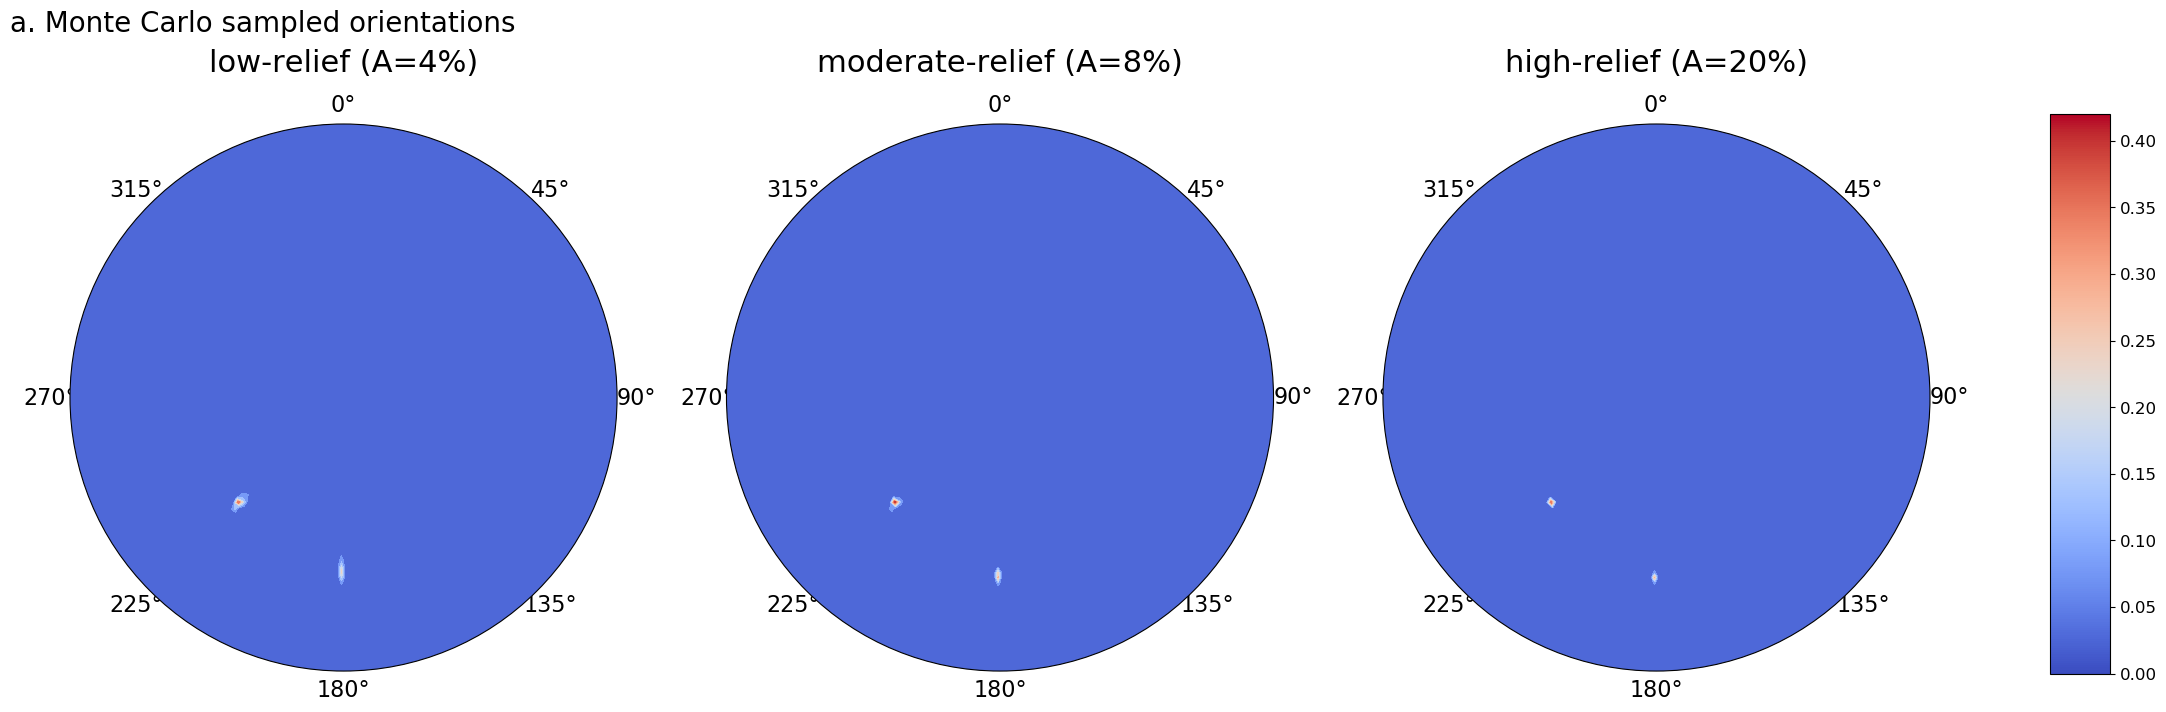

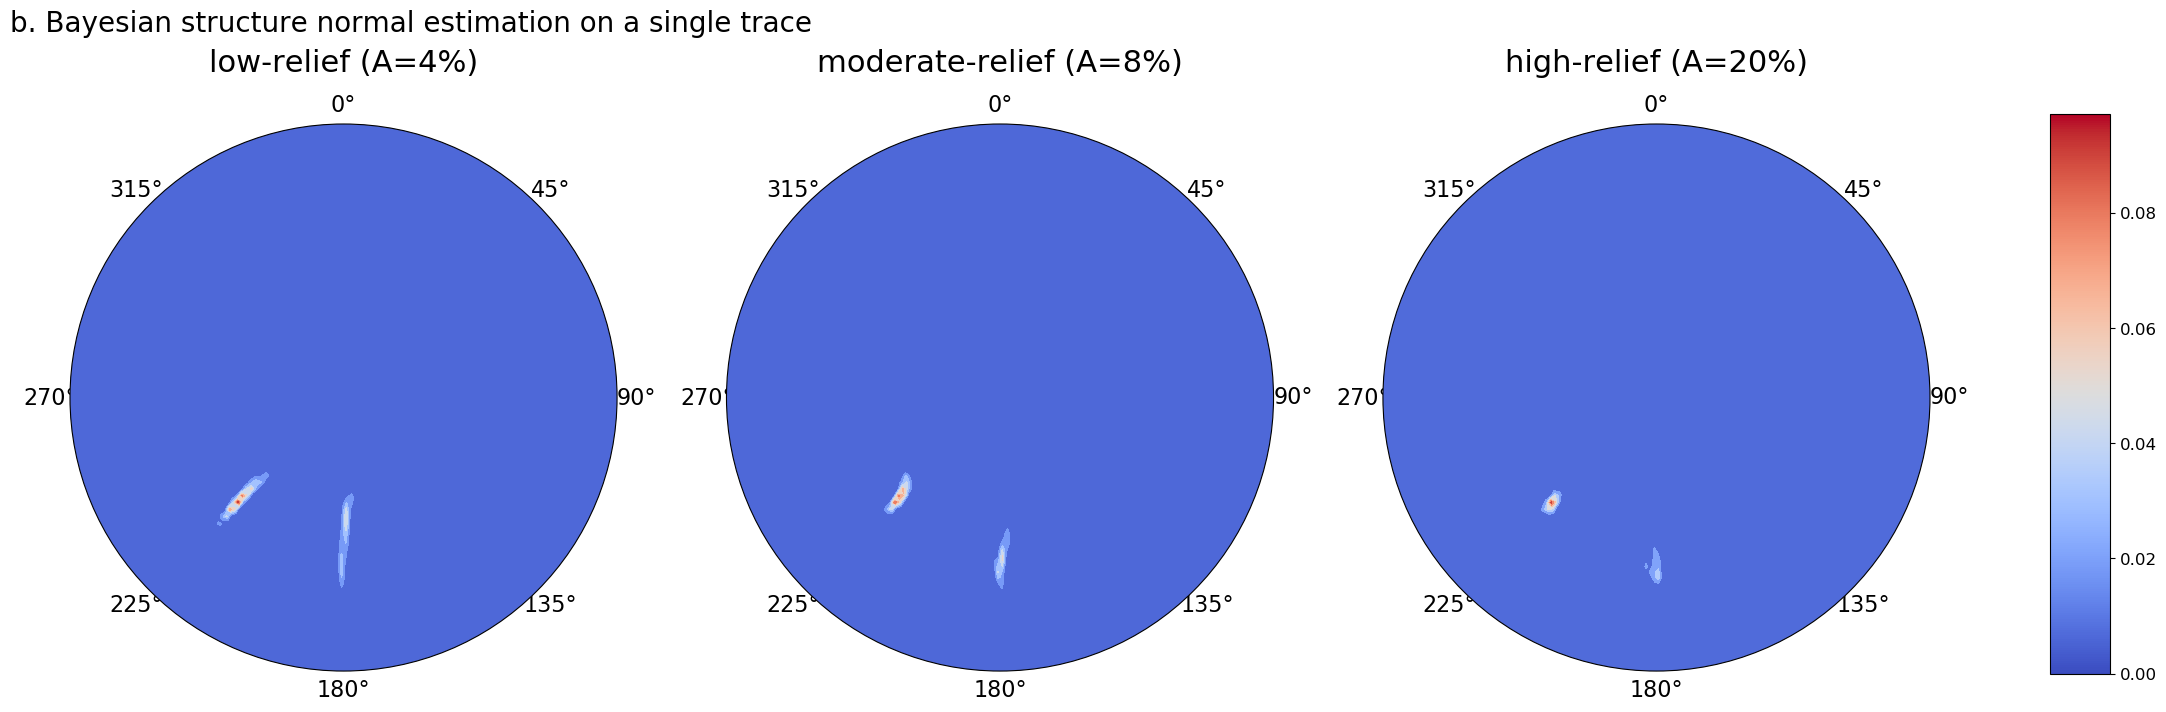

In [223]:
titles = ["low-relief (A=4%)","moderate-relief (A=8%)","high-relief (A=20%)"]

#plot monte-carlo results
fig = plotGrids(titles,grid,out_MC)
fig.suptitle("a. Monte Carlo sampled orientations",x=0.1, fontsize=20, ha='left')
fig.show()

#plot monte-carlo markov-chain results
fig = plotGrids(titles,grid,out_MCMC_grid)
fig.suptitle("b. Bayesian structure normal estimation on a single trace",x=0.1, fontsize=20, ha='left')
fig.show()